# Setup

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

# Instantiate a brand new model

In [2]:
# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
tcfg = TrainConfig()
print(cfg, '\n\n', tcfg)

# import the tokenizer specified by cfg
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = cfg.vocab_len)

# model modules
from modules.model import Model
model = Model(cfg).to(cfg.device)

# print the number of parameters in the model
print(f'\n{sum(p.numel() for p in model.parameters())/1e3}K parameters\n')
print(model)

ModelConfig(dim=32, device='cpu', tokenizer='bpe', vocab_len=8192, num_layers=32, second_resid_norm=False, mlp_hidden_mult=2, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=2, num_kv_heads=1, head_dim=16, theta=10000, max_seq_len=256, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 TrainConfig(weight_decay=0.05, batch_size=32, max_iters=5, eval_interval=5, eval_samples=1, checkpoint_interval=None, lr_init=0.0, lr_max=0.1, lr_min=0.0001, warmup_iters=0, final_flat_iters=1, anneal_type='cos', num_restarts=3, T_mult=2)

493.728K parameters

Model(
  (token_embedder): Embedding(8195, 32)
  (layers): ModuleList(
    (0-31): 32 x Layer(
      (pre_attn_norm): Norm()
      (attn): MQA(
        (Wq): Linear(in_features=32, out_features=32, bias=False)
        (Wk): Linear(in_features=32, out_features=16, bias=False)
        (Wv): Linear(in_features=32, out_features=16, bias=False)
        (Wo): Linear(in_featu

# Training

In [3]:
import torch
from tools import get_data_loader
from train import scheduler_lambda, train

optimizer = torch.optim.AdamW(model.parameters(), lr = tcfg.lr_max, weight_decay = tcfg.weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler_lambda)

train_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='train')
test_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='validation')

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


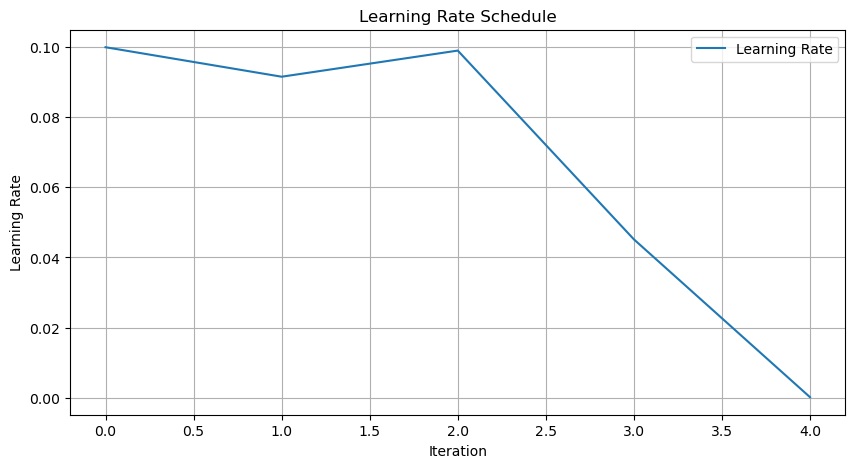

In [4]:
if True: # set to true if you'd like to see a graph of the learning rate schedule
    import matplotlib.pyplot as plt
    
    # Generate learning rate values
    lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
    # Plot the learning rates
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
model, optimizer, log_data = train(
    model, 
    tokenizer, 
    cfg, 
    optimizer,
    scheduler,
    tcfg, 
    train_data_loader,
    test_data_loader,
    #log_data: list = None, 
    #detect_anomoly = False # use if you're getting crazy errors about a the gradient being broken
)

 20%|█████▏                    | 1/5 [00:02<00:10,  2.57s/it]

step 0000: lr 0.010000, train loss 20.2424, val loss 20.2370, ppl 614896896, time elapsed: 1.58 seconds


100%|██████████████████████████| 5/5 [00:09<00:00,  1.81s/it]

step 0004: lr 0.000010, train loss 12.7879, val loss 12.8669, ppl 387297, time elapsed: 7.99 seconds


# inference test before you decide to save it

In [6]:
from inference import generate
prompt = "Once upon a time"
model.eval()
output = generate(
    prompt, 
    model, 
    tokenizer,
    #max_gen_len = 512,
    temperature = 0.7,
    #memory_saver_div = 8,
    #top_p = 0.9,
    #top_k = 32,
)
model.train()
print(output)

Once upon a timefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefivefive

# Saving your final model
if `tcfg.checkpoint_interval != None` then checkpoints have already been saved

you DO still need to do this even if you had been saving checkpoints; the final state has not yet been saved

In [7]:
from tools import save_model
save_model(model, cfg, tcfg, log_data)